<a href="https://colab.research.google.com/github/EvgeniyStrizhak/My-master-s-thesis/blob/main/Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Analysis
This section presents an exploratory data analysis (EDA) of the macro-economic indicators and the Frankfurt Stock Exchange (GDAXI) index. The objective is to understand the underlying patterns, trends, and relationships between the economic variables and the stock market index to prepare dataset to train machine learning models

##The Result:


###Target Variable:

The GDAXI index exhibits steady growth and demonstrates both trend and seasonal components. The seasonal components reflect varying levels of economic activity throughout the year, as well as long-term economic cycles such as crises and peaks.

The time series shows strong autocorrelation at short lags, indicating short-term memory. Additionally, many autocorrelation values exceed the confidence bounds and the ACF crosses zero around lag 90–100, suggesting the presence of long-term memory in the series.

To prepare the data for model training, the following preprocessing steps are required:

- Remove the trend component

- Make the series stationary using differencing

- Add lagged (shifted) values to capture seasonality

- Scale the data to standardize feature magnitudes

###Feature Variables:
Some features exhibit a consistent trend, which may lead to artificially strong correlations with the target variable. Others display strong negative correlations. Therefore, it is necessary to transform the features to ensure stationarity and reduce the influence of trends.

The features vary in scale, so normalization or standardization is required.
Additionally, some features—such as the industrial production index—may not contribute meaningfully to the model, highlighting the need for feature selection.

In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA

In [2]:
RANDOMSTATE = 1234
#link to GitHub repo where stock price is saved
TARGET_URL = 'https://raw.githubusercontent.com/EvgeniyStrizhak/My-master-s-thesis/refs/heads/main/row_datasets/target.csv'
TARGET_FILE_NAME = 'target.csv'
##link to GitHub repo where macroeconomics indicators are saved
FEATURE_URL = 'https://raw.githubusercontent.com/EvgeniyStrizhak/My-master-s-thesis/refs/heads/main/row_datasets/features.csv'
FEATURE_FILE_NAME = 'features.csv'

In [3]:
#geting data from url and saves it locally
def get_data(url, file_name):
  response = requests.get(url)

#Check if the request was successful
  if response.status_code == 200:
      # Save the file locally
      with open(file_name, "wb") as file:
          file.write(response.content)
      print(f"File downloaded successfully: {file_name}")
      return file_name
  else:
    print(f"Failed to download file: {file_name} Status code: {response.status_code}")
    return None

In [4]:
#function makes a line graph
def plot_data(data, column, ax):
    sns.lineplot(y=column, x='year', data=data, ax=ax)
    ax.set_xlabel('Year')
    ax.set_ylabel(column)
    ax.set_title(f'German {column} index')
    for label in ax.get_xticklabels():
        label.set_rotation(90)

In [5]:
#function decompose time series data into a trend, seasonal and residual components
def analize_season (period, lable):
    decomposed = seasonal_decompose(period)
    plt.figure(figsize=(20, 10))
    #data
    plt.subplot(2,2,1)
    plt.title('Data '+lable)
    plt.plot(period.index, period.values)
    #Trend
    plt.subplot(2,2,2)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend '+lable)
    #seasonal
    plt.subplot(2,2,3)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality '+lable)
    #residual
    plt.subplot(2,2,4)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals '+lable)
    plt.tight_layout()

Data Loading

In [6]:
#Download preprocessed data from GitHub
get_data(TARGET_URL, TARGET_FILE_NAME)
get_data(FEATURE_URL, FEATURE_FILE_NAME)

File downloaded successfully: target.csv
File downloaded successfully: features.csv


'features.csv'

In [7]:
#Create a dataframe
target = pd.read_csv('target.csv')
features = pd.read_csv('features.csv')
df = pd.merge(target, features, on=['year', 'month', 'quarter'], how='inner')
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

In [8]:
df.describe()

,^GDAXI,month,year,quarter,production_sector,gdp,consumer_prices,industrial_production_index,interest_rate,economy's_price competitiveness,unemployment_rate,labour_costs,mutual_funds_sales,orders-received,balance_of_payments,shares_sale,CL=F,date
count,243.000000,243.000000,243.00000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243.000000,243
mean,10186.944633,6.444444,2014.62963,2.481481,97.408230,96.460864,101.739506,94.414815,1.331893,93.518519,6.955556,88.586420,9746.201646,87.165432,14959.557551,3007.473251,72.117119,2015-01-30 20:56:17.777777664
min,3843.739990,1.000000,2005.00000,1.000000,78.100000,83.400000,84.500000,75.800000,0.000000,90.100000,4.900000,70.300000,-37827.000000,56.200000,-28449.198000,-25081.000000,18.840000,2005-01-01 00:00:00
25%,6599.145020,3.000000,2010.00000,1.000000,94.250000,90.790000,92.050000,85.650000,0.000000,92.600000,5.700000,77.000000,5112.500000,83.750000,6107.434500,-1030.500000,54.764999,2010-01-16 12:00:00
50%,9833.070312,6.000000,2015.00000,2.000000,98.800000,96.320000,99.700000,89.400000,0.750000,93.700000,6.500000,86.500000,9530.000000,88.200000,15006.198000,2183.000000,70.639999,2015-02-01 00:00:00
75%,12817.180176,9.000000,2020.00000,3.000000,100.900000,103.790000,105.750000,92.200000,2.500000,94.300000,7.700000,99.000000,13236.500000,91.950000,23522.114000,6386.000000,88.430000,2020-02-15 12:00:00
max,22551.429688,12.000000,2025.00000,4.000000,108.500000,105.350000,131.200000,142.300000,4.500000,97.300000,12.100000,117.700000,50401.000000,107.500000,69342.817000,28911.000000,140.000000,2025-03-01 00:00:00
std,4115.368274,3.474821,5.85876,1.125708,5.988558,6.911831,12.130683,16.058646,1.526306,1.548001,1.764245,13.373575,8657.121712,8.428197,14513.346319,6842.153394,21.064901,NaN


The data does not contain outliers, missing values, or other data quality issues.

#Data Analysis

### GDAXI Index Dynamic Overview

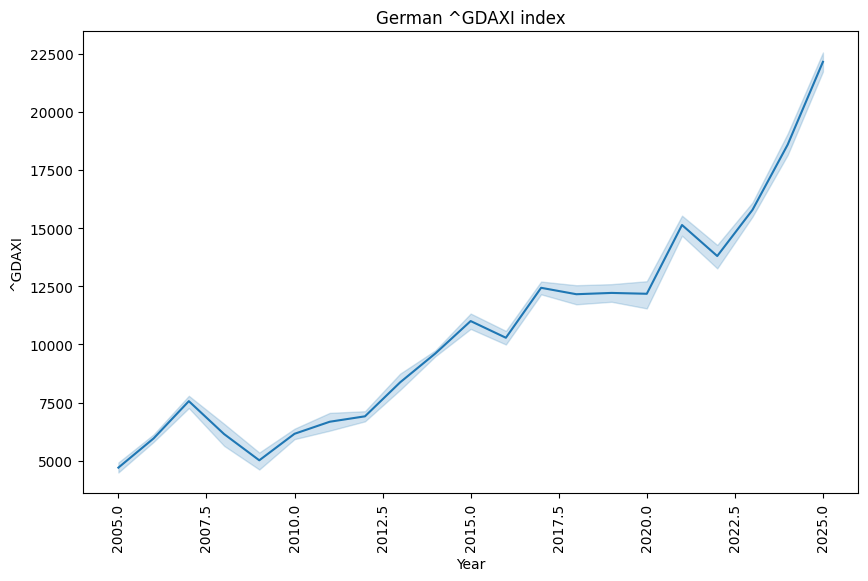

In [9]:
plt.figure(figsize=(10, 6))

plot_data(df, '^GDAXI', plt.gca())

The line graph shows the dynamics of the target variable, the GDAXI index. Overall, the index has shown steady growth over the analyzed period, with notable declines during the 2008 financial crisis and the COVID-19 pandemic.

### GDAXI Histogram Overview

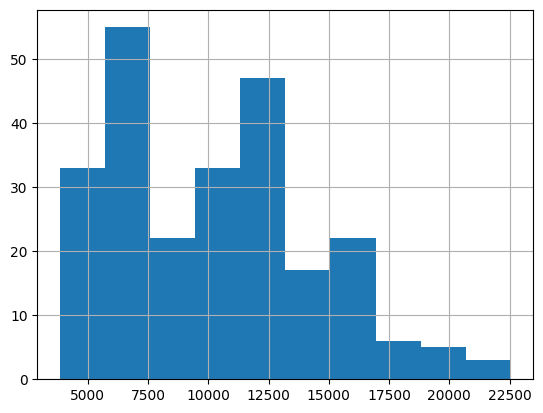

In [10]:
df['^GDAXI'].hist();

The histogram suggests that the GDAXI index:

Has multiple common value ranges (multimodal).

Experienced sharp rises over time (values clustered around 5k–7k, 10k–13k, and fewer high-value counts).

May have longer periods at lower index levels, with only recent years reaching >15,000.

Likely non-stationary, requiring differencing or detrending before modeling.

### Macroeconomic Indicators Dynamic Overview

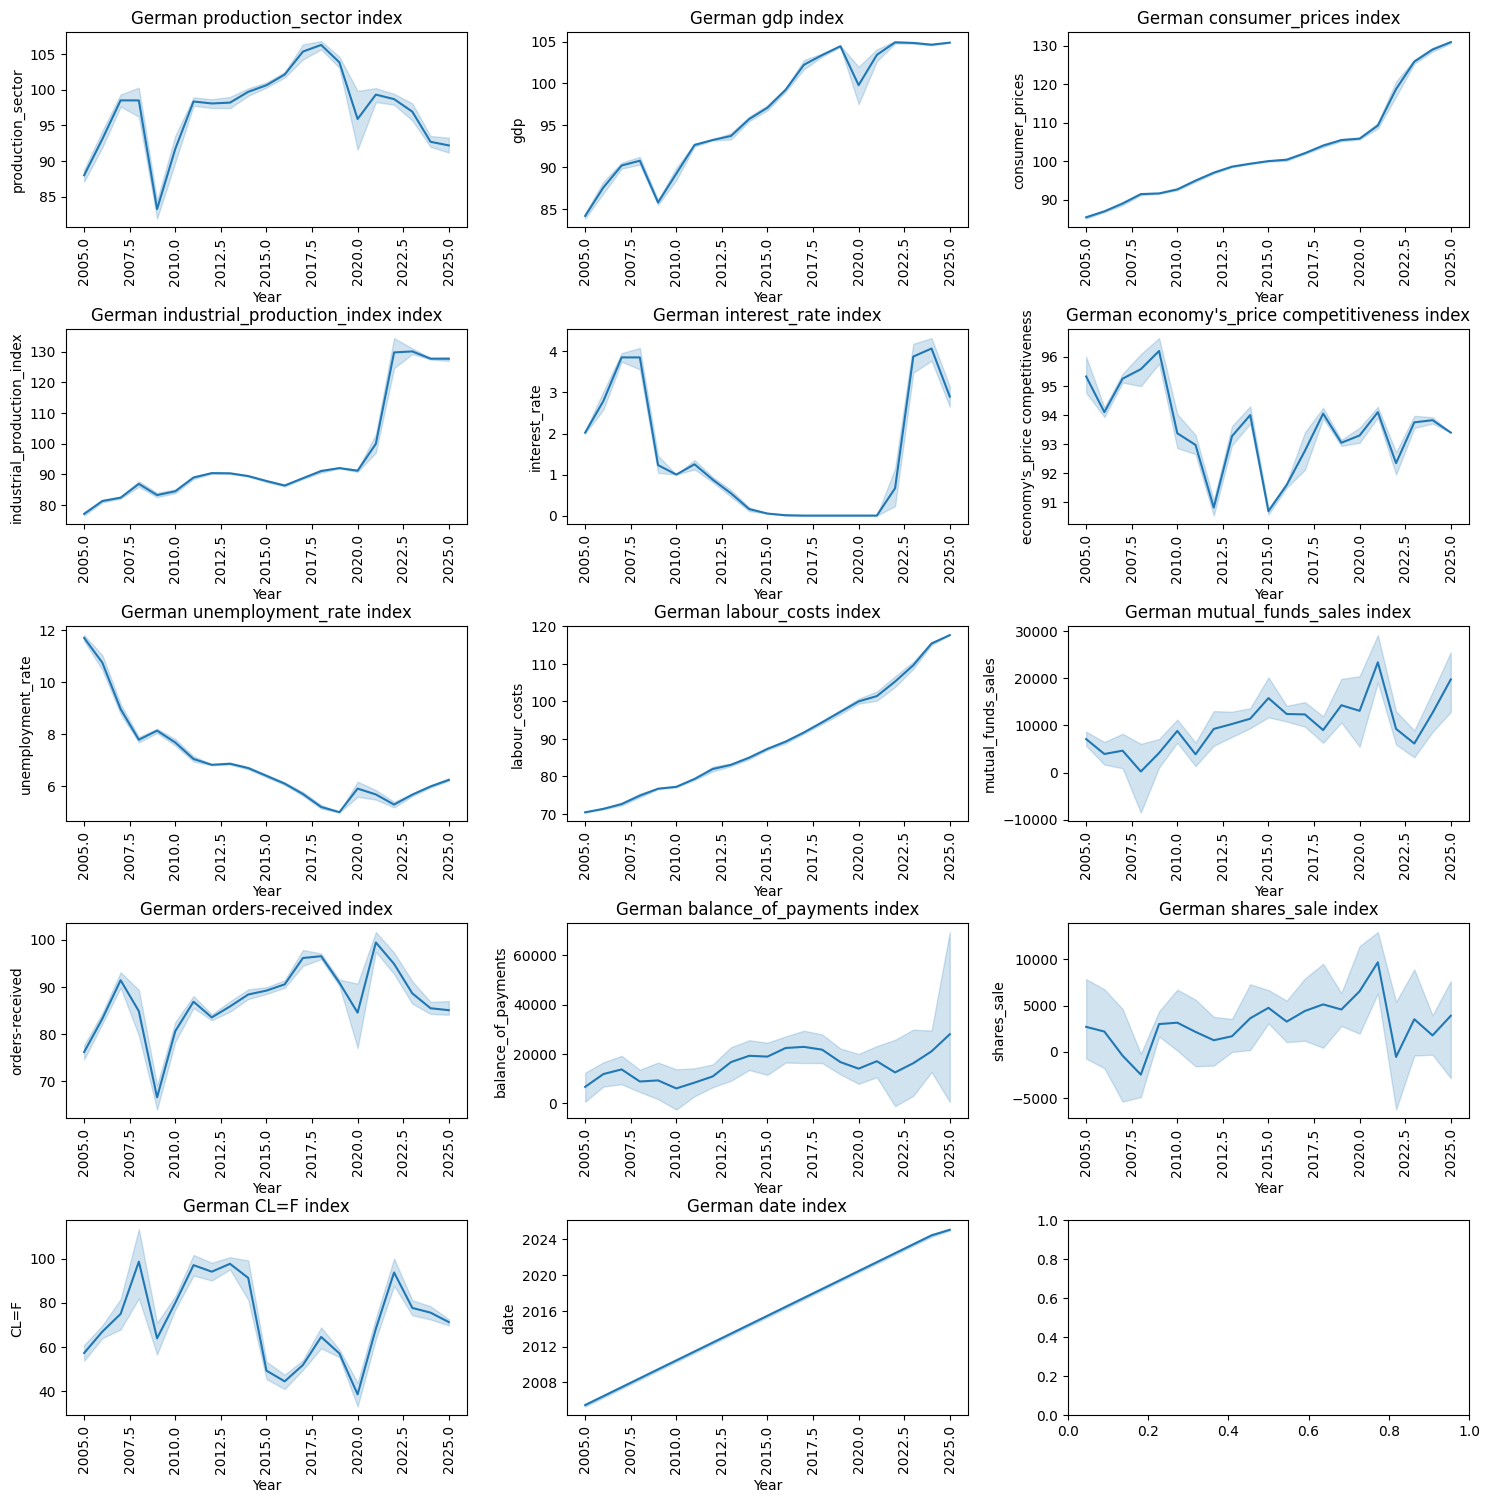

In [11]:
#make a grid of features line graphs
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
#select features
columns = df.columns[4:]

for i, column in enumerate(columns):
#calculate row index
  row = i // 3
#calculate column index
  col = i % 3
  plot_data(df, column, axes[row, col])

#adjust spacing between subplots
plt.tight_layout()
plt.show()

The German manufacturing sector demonstrates a different dynamic and may not be a significant factor in forecasting the stock market. German industry is rapidly losing its role in the national economy. Over the analyzed period, it grew by only 5%, while Germany's GDP increased by 20%.

In contrast, the unemployment rate exhibits a negative correlation with both economic growth and stock market performance.

GDP, labor costs, and the consumer price index display similar trends, suggesting a potential linear relationship between these macroeconomic indicators and the stock market index.

The interest rate index reflects broader economic trends: interest rates tend to rise during economic crises and decline during periods of growth.

The balance of payments, mutual fund sales, and stock sales show increased volatility during periods of crisis.


### Correlation Analysis of a Stock Market Price and Macroeconomic Indicators

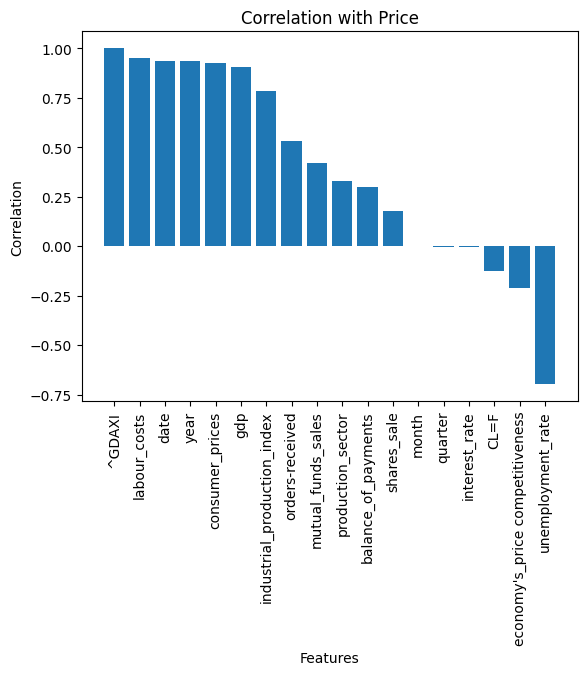

In [12]:
corr_bf = df.corr()['^GDAXI'].sort_values(ascending=False)
plt.bar(corr_bf.index, corr_bf.values)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.title('Correlation with Price')
plt.show()

As shown in the previously created graph, not all uploaded features are necessarily useful for predicting stock market performance. Correlation analysis indicates that variables such as month, quarter, share sales, oil prices, and economic price competitiveness exhibit low correlation with the target variable. Conversely, the steady rise in key macroeconomic indicators appears to be closely linked to stock market trends. Features such as year, date, and consumer prices may reflect the overall trend but could still be of limited predictive value. Therefore, it is essential to analyze the trend, seasonality, and residuals of the time series to better understand its underlying structure and improve model performance.

###Seasonality Component Analysis

/tmp/ipython-input-13-255187294.py:1: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  monthly = df[(df['date'] <= pd.to_datetime('31.12.2023')) & (df['date'] >=


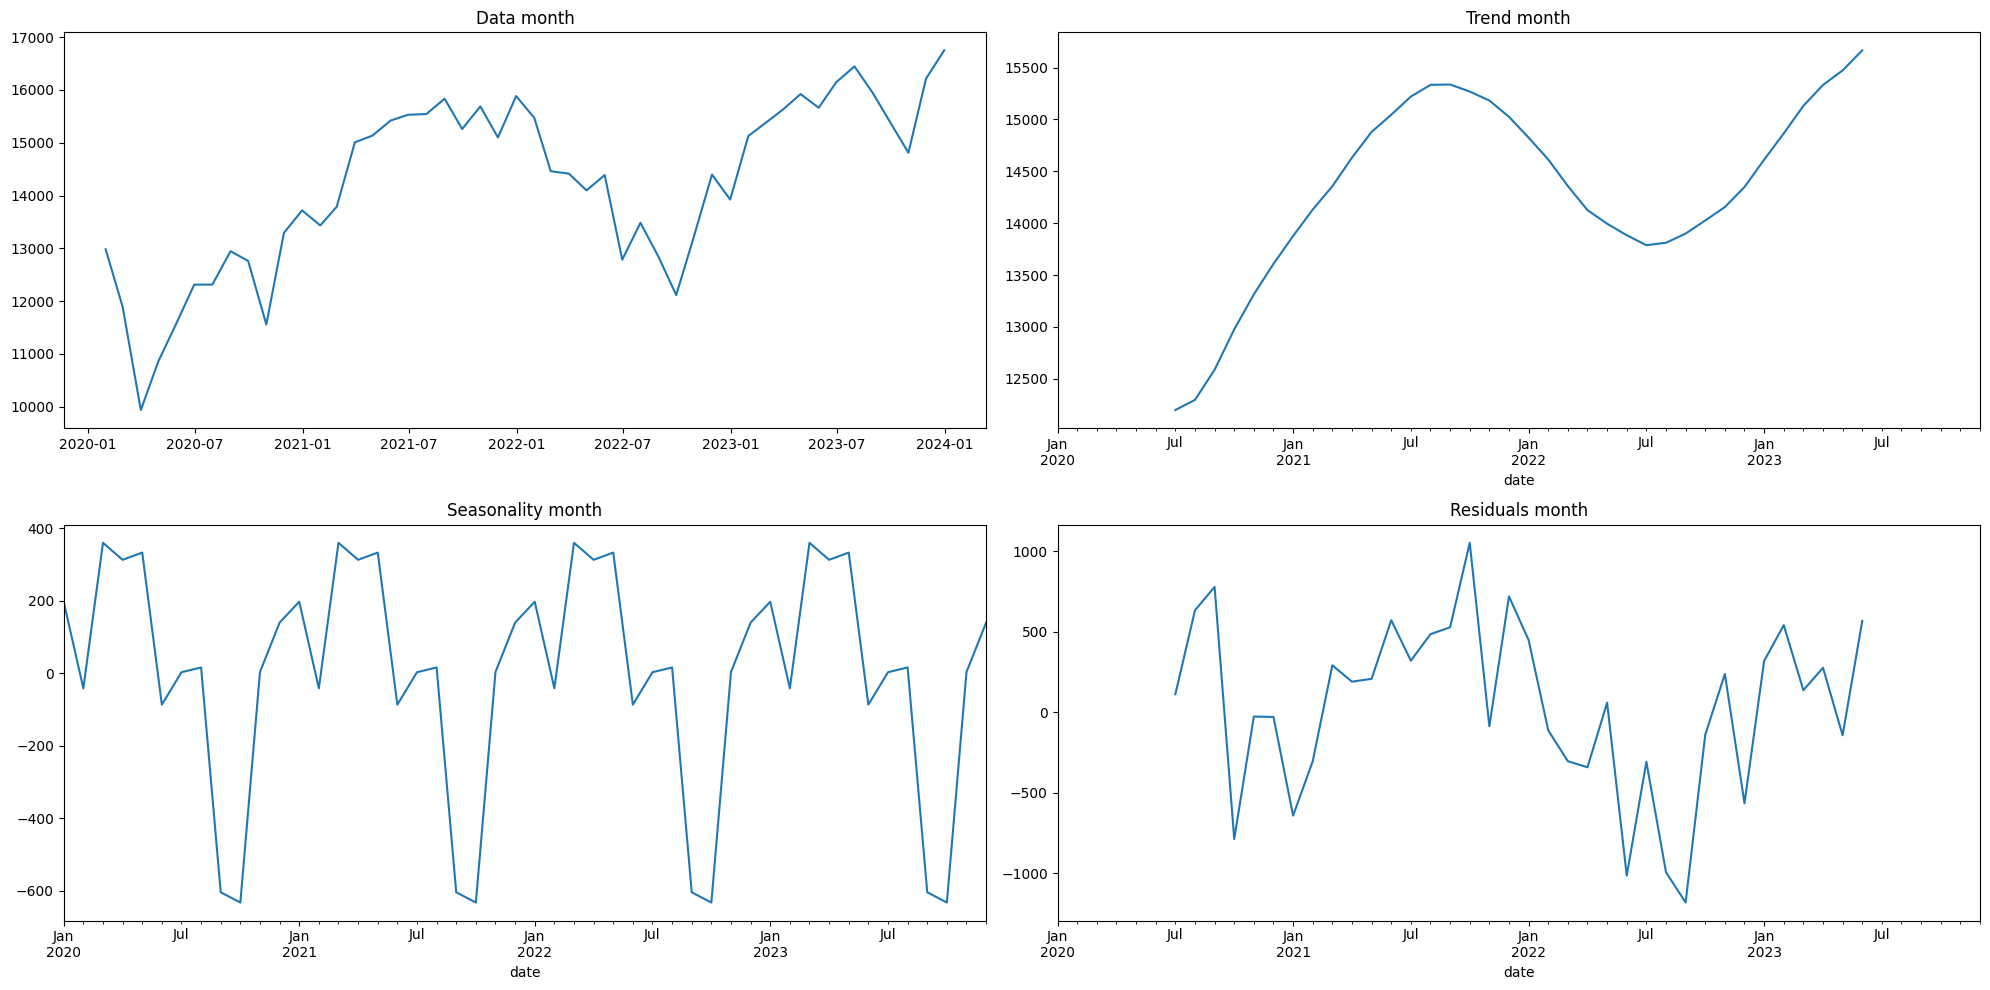

In [13]:
monthly = df[(df['date'] <= pd.to_datetime('31.12.2023')) & (df['date'] >=
             pd.to_datetime('01.01.2020'))].resample('ME', on='date').mean()
analize_season(monthly['^GDAXI'], 'month')

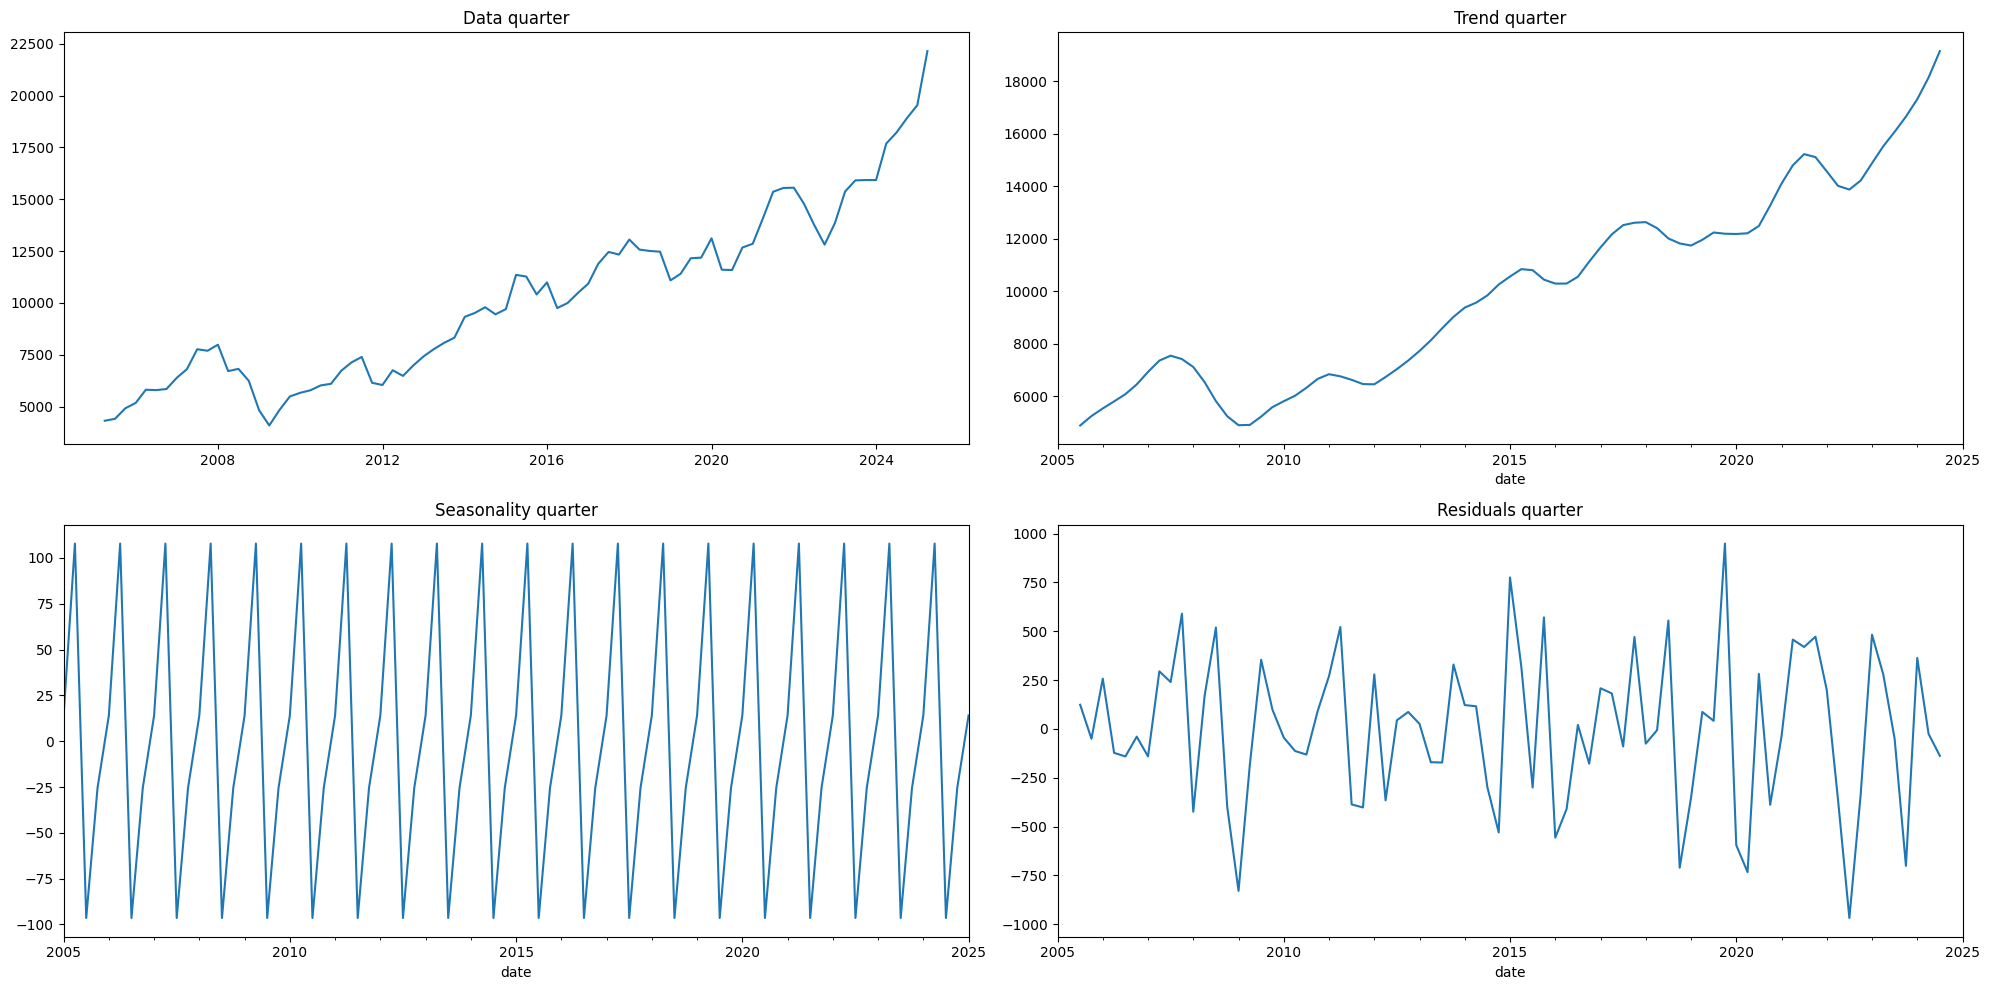

In [14]:
quarter = df.resample('QE', on='date').mean()
analize_season(quarter['^GDAXI'], 'quarter')

The stock market price oscillates from month to month throughout the year. Therefore, we can incorporate the price of the previous month and the price from a year ago as a feature in order to reduce the seasonal component.


###Analysis of Autocorrelation

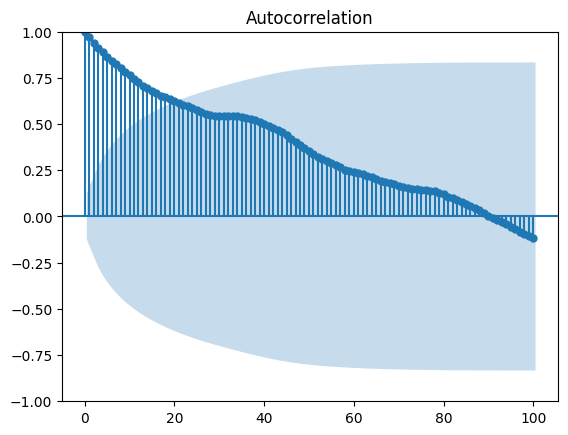

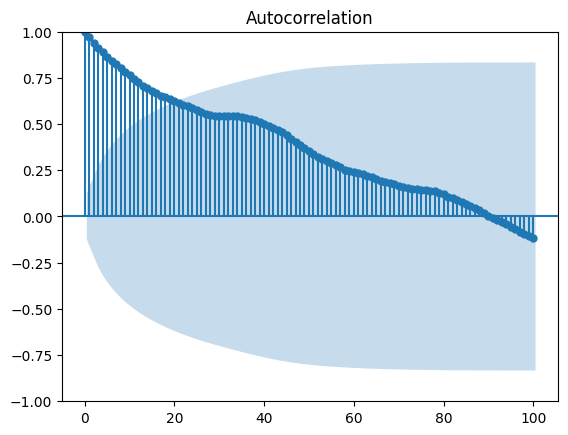

In [15]:
plot_acf(target['^GDAXI'], lags=100)

- There is strong autocorrelation at short lags: from lag 1 to approximately lag 60, all values are significantly positive, exceeding the confidence bounds.
- The autocorrelation function (ACF) exhibits a slow decay, which is typical of data with a trend, particularly an upward trend.
- The ACF crosses zero around lag 90–100, indicating the presence of long-term memory in the time series.